# Glove vs DAN

We want to illustrate the the Feedforward Layers of an DAN learn a more abstract representation then simple bow-averaging, so that each layer will increasingly magnify small but meaningful differences in the word embedding average.

Notes:
___

1. For PCA are to similar sentences shit.. 
2. T-SNE -> Results are shit. How does this algorithm work??
3. PFFFF

4. Maybe it looks much better in a 3D Plot


Try this whole shit with.. Trained USE

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf 
import tensorflow_hub as tf_hub
import seaborn as sns
from typing import *

In [3]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.keyedvectors import KeyedVectors

In [4]:
# Implementing TFhub env
os.environ["TFHUB_CACHE_DIR"] = '/tfhub'
model_url = "https://tfhub.dev/google/universal-sentence-encoder/2"

model_use = tf_hub.Module(model_url, trainable=False)

INFO:tensorflow:Using /tfhub to cache modules.


In [5]:
# https://nlp.stanford.edu/projects/glove
glove_vecs = "/Users/Daniel/Downloads/glove.6B/glove.6B.300d.txt"
word2vec_out = "/Users/Daniel/Downloads/glove.6B/w2v.6B.300d.txt" # Place for transformed GloveFiles

In [6]:
s1 = "i want to predict costs"
s2 = "i want to predict the stock price"
s3 = "i want to find sequence pattern"
s4 = "i want similar costs"

sentences = [s1,s2,s3, s4]

## Transforming Glove Vectors to Word2Vec Format

In [7]:
%%time
# glove2word2vec(glove_input_file=glove_vecs, word2vec_output_file=word2vec_out)
glove_model = KeyedVectors.load_word2vec_format(word2vec_out, binary=False)

CPU times: user 2min 10s, sys: 2.56 s, total: 2min 13s
Wall time: 2min 17s


## Sentences to Vectors

In [8]:
%%time
_dict = {}
with tf.Session() as session: 
    # Initializing global variables in the graph 
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    
    sentence_embeddings = session.run(model_use(sentences))
    for index, se in enumerate(sentence_embeddings):
        _dict.update({sentences[index]: se})

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
CPU times: user 25.1 s, sys: 6.42 s, total: 31.5 s
Wall time: 31.3 s


In [9]:
_dict.keys()

dict_keys(['i want to predict costs', 'i want to predict the stock price', 'i want to find sequence pattern', 'i want similar costs'])

### GLOVE

#### Creating word set

In [10]:
### getting every word
from nltk.tokenize import word_tokenize
word_set = set()

for sentence in sentences:
    words = word_tokenize(sentence)
    for word in words: 
        word_set.add(word)

#### Getting word vectors

In [11]:
_dict_words = {}

for word in word_set: 
    _dict_words.update({word: glove_model[word]})

In [12]:
_dict_words.keys()

dict_keys(['find', 'to', 'pattern', 'similar', 'predict', 'costs', 'sequence', 'i', 'want', 'price', 'stock', 'the'])

#### Averaging words

In [13]:
def calculate_average(bag_of_words: List[np.ndarray]):
    _vector_sum = np.zeros((300,))
    for x in bag_of_words:
        _vector_sum += x
       
    return (_vector_sum/len(bag_of_words))

In [14]:
_dict_averages = {}
for sentence in sentences:
    bag_of_words = []
    for word in _dict_words.keys():
        if word in sentence: 
            bag_of_words.append(_dict_words[word])
    average = calculate_average(bag_of_words)
    _dict_averages.update({sentence: average})

In [15]:
_dict_averages.keys()

dict_keys(['i want to predict costs', 'i want to predict the stock price', 'i want to find sequence pattern', 'i want similar costs'])

In [16]:
#_dict_averages

### Dimensionality Reduction

In [17]:
from sklearn.decomposition import PCA

In [18]:
pca_USE = PCA(n_components=2)
pca_glove = PCA(n_components=2)

In [19]:
vectors_use = []

for sentence in sentences: 
    vectors_use.append(_dict[sentence])
    
vectors_glove = []
for sentence in sentences: 
    vectors_glove.append(_dict_averages[sentence])

In [20]:
matrix_use = pca_USE.fit_transform(vectors_use)
matrix_glove = pca_glove.fit_transform(vectors_glove)

In [21]:
df_use = pd.DataFrame(data = {"sentence": sentences,      
                    "x": matrix_use[:,0],
                    "y": matrix_use[:,1]
                    })

df_glove = pd.DataFrame(data = {"sentence": sentences,      
                    "x": matrix_glove[:,0],
                    "y": matrix_glove[:,1]
                    })

In [22]:
df_use

,sentence,x,y
0,i want to predict costs,-0.305399,-0.102889
1,i want to predict the stock price,-0.190863,-0.580479
2,i want to find sequence pattern,0.809887,0.064180
3,i want similar costs,-0.313625,0.619189


In [23]:
df_glove

,sentence,x,y
0,i want to predict costs,-0.651092,-0.066004
1,i want to predict the stock price,-0.563146,1.229694
2,i want to find sequence pattern,1.715635,0.029793
3,i want similar costs,-0.501397,-1.193483


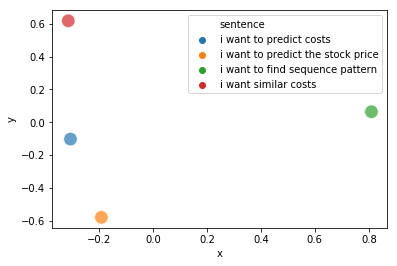

In [24]:
ax = sns.scatterplot(x="x", y="y", hue="sentence", s = 180, alpha = 0.7, legend = "full", data=df_use)


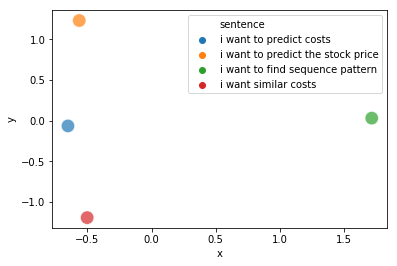

In [25]:
sns.scatterplot(x="x", y="y", hue="sentence", s = 180, alpha = 0.7, legend = "full",data=df_glove)


In [26]:
# U can can cheat better with an 3D plot